# Visión por Computadora II - TP Integrador

**Dataset**: [fruits-360](https://www.kaggle.com/datasets/moltean/fruits)

In [39]:
# importamos librerias
!pip install torchmetrics --quiet

import os
import shutil
import gdown
import time
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import pandas as pd
import pickle
import math
from PIL import Image
from collections import Counter

import torch
import torchvision
import torchmetrics
from torch.utils.data import DataLoader
from torchvision.models.vgg import VGG19_Weights
from torchvision.models import mobilenet_v2

---
## 1) Dataset

In [2]:
dataset_zip = 'fruits-360_100x100.zip'
%store dataset_zip

# Descargar el dataset
if os.access(dataset_zip, os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=114La2Plk0fj1PmGlwVUGLUohcEwDKvcL'
    gdown.download(url, dataset_zip)
else:
    print("El dataset ya se encuentra descargado")

Stored 'dataset_zip' (str)


Downloading...
From (original): https://drive.google.com/uc?id=114La2Plk0fj1PmGlwVUGLUohcEwDKvcL
From (redirected): https://drive.google.com/uc?id=114La2Plk0fj1PmGlwVUGLUohcEwDKvcL&confirm=t&uuid=a6605b55-782e-4069-b1f0-a08abdf502ef
To: /content/fruits-360_100x100.zip
100%|██████████| 423M/423M [00:12<00:00, 32.8MB/s]


In [3]:
!unzip -o -q "$dataset_zip"

---
### 1.1) Análisis exploratorio

- El dataset Fruit-360 es una colección diseñada específicamente para tareas de clasificación de frutas. Contiene un total de 81 clases, cada una representando una categoría diferente de frutas. El conjunto de datos está organizado en:
   - Conjunto de entrenamiento: 70491 imágenes.
   - Conjunto de prueba: 23619 imágenes.
   - En total, el dataset incluye 94110 imágenes.

- Para capturar las imágenes, se utilizó un motor de baja velocidad (3 rpm) que giraba las frutas, grabando un corto video de 20 segundos. Debido a las variaciones en las condiciones de iluminación durante las filmaciones, los fondos originales no eran uniformes. Por esta razón, se estandarizó el fondo de todas las imágenes, convirtiéndolo en color blanco.

- Cada imagen tiene un tamaño de 100x100 píxeles con fondo blanco. Esta resolución y uniformidad son esenciales para la clasificación de imágenes, ya que muchas frutas comparten colores y formas similares, aunque difieren en tamaño. A su vez, algunas frutas tienen el mismo tamaño, color y forma, pero pertenecen a diferentes variedades dentro de una misma categoría (por ejemplo, variantes de manzanas, mangos o tomates). Para abordar esta diversidad, las distintas variantes de una misma fruta se clasificaron como clases separadas.

- A diferencia de otros datasets generales de clasificación de imágenes, el Fruit-360 se enfoca exclusivamente en frutas. Esto implica un desafío adicional debido a las grandes similitudes intra-clase, ya que frutas de la misma categoría comparten características visuales muy similares. Por lo tanto, este dataset representa un excelente punto de partida para explorar las capacidades de modelos de clasificación de imágenes y analizar su rendimiento frente a clases con características sutilmente diferenciadas.

In [4]:
# imprimir cantidad de imagenes de train y test
train_folder_raw = 'Training/'
test_folder_raw = 'Test/'

train_images_raw = sum([len(files) for r, d, files in os.walk(train_folder_raw)])
test_images_raw = sum([len(files) for r, d, files in os.walk(test_folder_raw)])
total_images_raw = train_images_raw + test_images_raw

print(f"Cantidad de imagenes en train: {train_images_raw}")
print(f"Cantidad de imagenes en test: {test_images_raw}")
print(f"Total de imagenes: {total_images_raw}")

Cantidad de imagenes en train: 70491
Cantidad de imagenes en test: 23619
Total de imagenes: 94110


In [5]:
# exploracion de las clases del dataset raw
classes_raw = os.listdir(train_folder_raw)
print(f"Se encontraron {len(classes_raw)} clases de frutas")
print(f"Primeras 10 clases:")
print(classes_raw[:10])

Se encontraron 141 clases de frutas
Primeras 10 clases:
['Pineapple Mini 1', 'Pear Red 1', 'Potato Red 1', 'Apple Braeburn 1', 'Grape Pink 1', 'Avocado 1', 'Apple Red 3', 'Maracuja 1', 'Potato Red Washed 1', 'Tangelo 1']


In [6]:
# tamaño de las imágenes
image_shapes = []
for cls in classes_raw:
    folder = os.path.join(train_folder_raw, cls)
    for img_file in os.listdir(folder):
        img_path = os.path.join(folder, img_file)
        img = Image.open(img_path)
        image_shapes.append(img.size)

widths, heights = zip(*image_shapes)
print(f"Tamaño promedio de las imágenes: {np.mean(widths):.2f}x{np.mean(heights):.2f}")
print(f"Tamaño mínimo: {min(widths)}x{min(heights)}, máximo: {max(widths)}x{max(heights)}")

Tamaño promedio de las imágenes: 100.00x100.00
Tamaño mínimo: 100x100, máximo: 100x100


---
### 1.2) Preparación de los datos

In [7]:
# Funcion para mergear las clases que corresponden a la misma fruta/verdura
def merge_classes(original_dir, merged_dir):
    class_mapping = {}
    if os.path.exists(merged_dir):
        shutil.rmtree(merged_dir)
    os.makedirs(merged_dir, exist_ok=True)

    for folder_name in os.listdir(original_dir):
        match = re.match(r"([a-zA-Z ]+)", folder_name)
        if match:
            base_class_name = match.group(1).strip()
            class_mapping[folder_name] = base_class_name

    for original_class, new_class in class_mapping.items():
        new_class_dir = os.path.join(merged_dir, new_class)
        original_class_dir = os.path.join(original_dir, original_class)

        os.makedirs(new_class_dir, exist_ok=True)

        if os.path.exists(original_class_dir):
            for filename in os.listdir(original_class_dir):
                match = re.search(r"\d+$", original_class)
                suffix = match.group(0) if match else ""

                new_filename = f"{os.path.splitext(filename)[0]}_{suffix}{os.path.splitext(filename)[1]}"
                destination_path = os.path.join(new_class_dir, new_filename)

                shutil.copy(os.path.join(original_class_dir, filename), destination_path)

    print(f"Clases mergeadas en en {merged_dir}.")

train_folder = 'Training_merged/'
test_folder = 'Test_merged/'

merge_classes(train_folder_raw, train_folder)
merge_classes(test_folder_raw, test_folder)

Clases mergeadas en en Training_merged/.
Clases mergeadas en en Test_merged/.


In [8]:
# imprimir cantidad de imagenes de train y test
train_images = sum([len(files) for r, d, files in os.walk(train_folder)])
test_images = sum([len(files) for r, d, files in os.walk(test_folder)])
total_images = train_images + test_images

print(f"Cantidad de imagenes en train: {train_images}")
print(f"Cantidad de imagenes en test: {test_images}")
print(f"Total de imagenes: {total_images}")

Cantidad de imagenes en train: 70491
Cantidad de imagenes en test: 23619
Total de imagenes: 94110


In [9]:
# exploracion de las clases del dataset
classes = os.listdir(train_folder)
print(f"Se encontraron {len(classes)} clases de frutas/verduras")
print(f"Primeras 10 clases:")
print(classes[:10])

Se encontraron 121 clases de frutas/verduras
Primeras 10 clases:
['Pineapple Mini', 'Tomato Maroon', 'Banana Red', 'Carrot', 'Mulberry', 'Cherry Rainier', 'Clementine', 'Blueberry', 'Watermelon', 'Cocos']


In [10]:
# cantidad de imágenes por clase
class_counts = {cls: len(os.listdir(os.path.join(train_folder, cls))) for cls in classes}
sorted_class_counts = dict(sorted(class_counts.items(), key=lambda item: item[1], reverse=True))
print(f"Cantidad de imágenes por clase:")
print(sorted_class_counts)

Cantidad de imágenes por clase:
{'Tomato': 2627, 'Grape White': 1943, 'Plum': 1767, 'Apple Golden': 1453, 'Apple Red': 1413, 'Pear': 1403, 'Peach': 1230, 'Cherry': 1230, 'Apple Red Yellow': 1164, 'Grape Blue': 984, 'Cantaloupe': 984, 'Cucumber Ripe': 860, 'Cherry Rainier': 738, 'Strawberry Wedge': 738, 'Melon Piel de Sapo': 738, 'Walnut': 735, 'Pear Stone': 711, 'Pepper Orange': 702, 'Apple hit': 702, 'Pear Forelle': 702, 'Cauliflower': 702, 'Fig': 702, 'Tomato Heart': 684, 'Pepper Red': 666, 'Pepper Yellow': 666, 'Pear Red': 666, 'Nut Forest': 654, 'Nut Pecan': 534, 'Pineapple Mini': 493, 'Mulberry': 492, 'Apple Granny Smith': 492, 'Cherry Wax Yellow': 492, 'Grapefruit White': 492, 'Grape Pink': 492, 'Apricot': 492, 'Lemon': 492, 'Physalis with Husk': 492, 'Rambutan': 492, 'Pomegranate': 492, 'Cherry Wax Black': 492, 'Strawberry': 492, 'Physalis': 492, 'Peach Flat': 492, 'Redcurrant': 492, 'Cherry Wax Red': 492, 'Apple Braeburn': 492, 'Nectarine': 492, 'Papaya': 492, 'Tomato Cherry Re

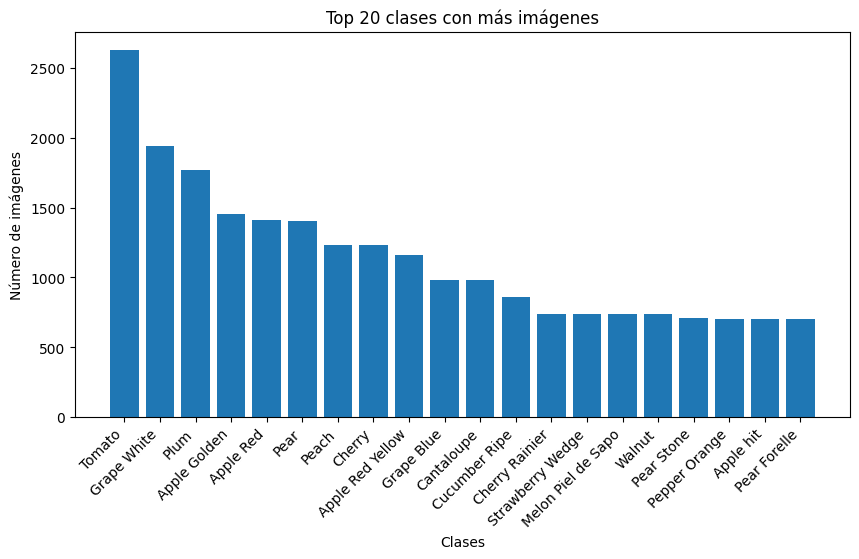

In [11]:
# visualizamos las clases con más imágenes
top_classes = dict(Counter(class_counts).most_common(20))
plt.figure(figsize=(10, 5))
plt.bar(top_classes.keys(), top_classes.values())
plt.title("Top 20 clases con más imágenes")
plt.xlabel("Clases")
plt.ylabel("Número de imágenes")
plt.xticks(rotation=45, ha="right")
plt.show()

---
### 1.3) Visualización de los datos

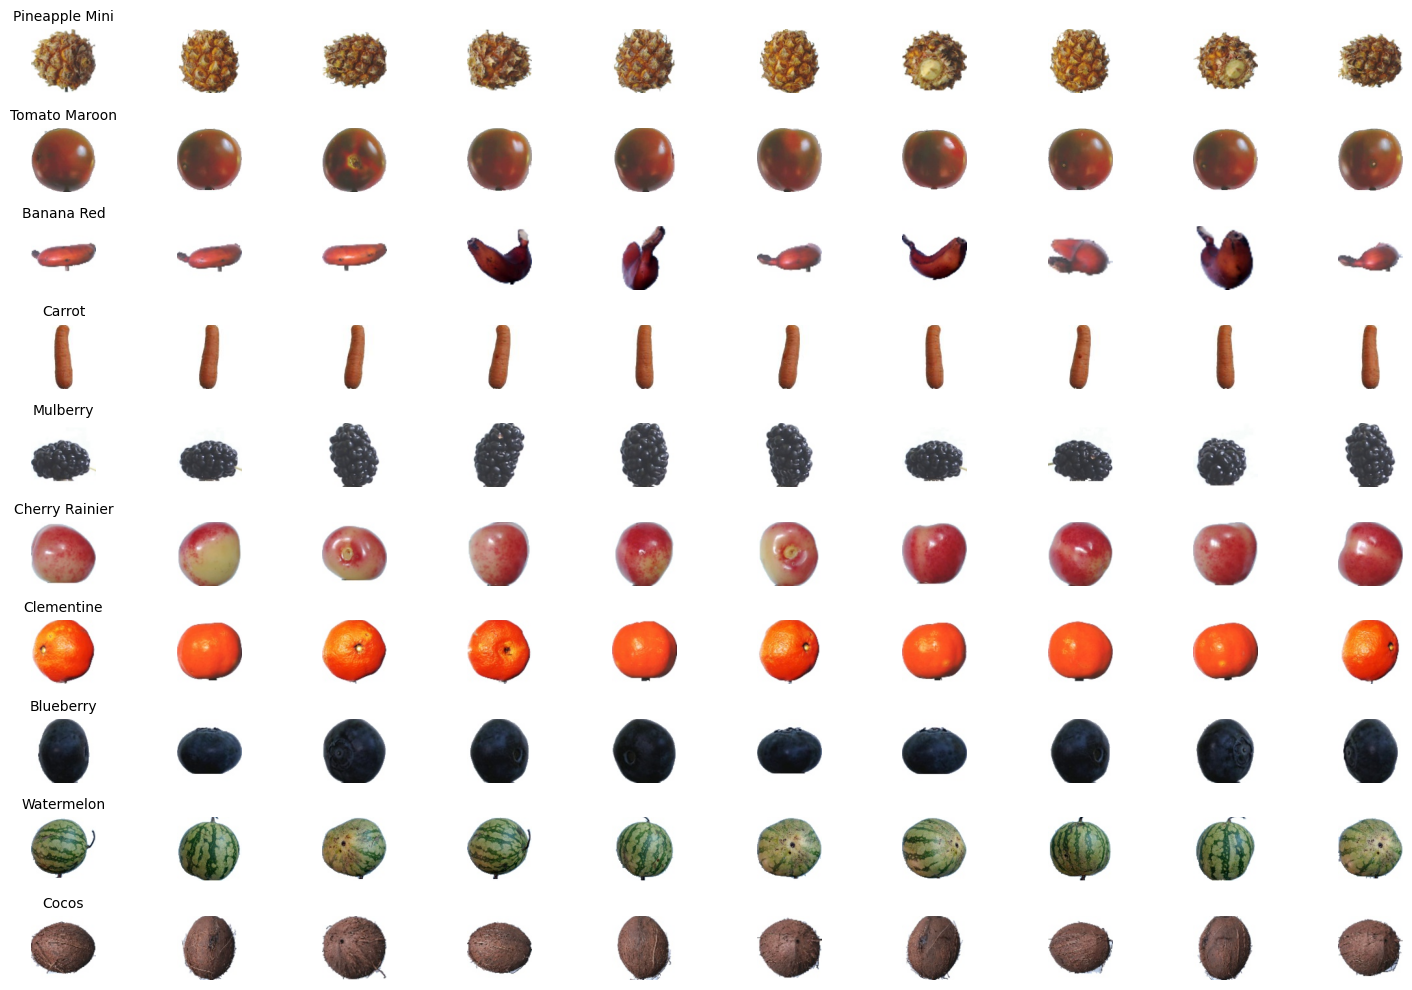

In [12]:
# visualiza imágenes de ejemplo
def mostrar_ejemplos(data_dir, classes, num_imagenes=5):
    fig, axes = plt.subplots(len(classes), num_imagenes, figsize=(15, 10))
    for i, cls in enumerate(classes):
        folder = os.path.join(data_dir, cls)
        images = os.listdir(folder)[:num_imagenes]
        for j, img_file in enumerate(images):
            img_path = os.path.join(folder, img_file)
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(cls, fontsize=10)
    plt.tight_layout()
    plt.show()

mostrar_ejemplos(train_folder, classes[:10], num_imagenes=10)

---
### 1.4) Dataset reducido

Se utiliza un dataset reducido para acelerar el entrenamiento en la búsqueda de hiperparámetros.

In [73]:
def create_subset_folder(original_dir, subset_dir, classes_subset, images_per_class):
    if os.path.exists(subset_dir):
        shutil.rmtree(subset_dir)
    os.makedirs(subset_dir, exist_ok=True)

    for class_name in classes_subset:
        class_subset_dir = os.path.join(subset_dir, class_name)
        os.makedirs(class_subset_dir, exist_ok=True)

        image_files = [f for f in os.listdir(os.path.join(original_dir, class_name)) if os.path.isfile(os.path.join(original_dir, class_name, f))]
        selected_images = random.sample(image_files, min(images_per_class, len(image_files)))

        for image_file in selected_images:
            source_path = os.path.join(original_dir, class_name, image_file)
            destination_path = os.path.join(class_subset_dir, image_file)
            shutil.copy(source_path, destination_path)

num_classes_subset = 40
images_per_class = 50

random.seed(42)
class_folders = [f for f in os.listdir(train_folder) if os.path.isdir(os.path.join(train_folder, f))]
classes_subset = random.sample(class_folders, num_classes_subset)
classes_subset.sort()
print("Clases elegidas para el dataset reducido:")
print(classes_subset)

# Directorios para el subset
train_subset_folder = 'Training_subset'
test_subset_folder = 'Test_subset'
create_subset_folder(train_folder, train_subset_folder, classes_subset, int(images_per_class*0.8))
create_subset_folder(test_folder, test_subset_folder, classes_subset, int(images_per_class*0.2))

train_subset_images = sum([len(files) for r, d, files in os.walk(train_subset_folder)])
test_subset_images = sum([len(files) for r, d, files in os.walk(test_subset_folder)])
total_subset_images = train_subset_images + test_subset_images

print("")
print(f"Cantidad de imagenes en train subset: {train_subset_images}")
print(f"Cantidad de imagenes en test subset: {test_subset_images}")
print(f"Total de imagenes subset: {total_subset_images}")

Clases elegidas para el dataset reducido:
['Apple', 'Apple Braeburn', 'Apple hit', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Cantaloupe', 'Carrot', 'Corn Husk', 'Cucumber Ripe', 'Dates', 'Eggplant', 'Granadilla', 'Grape White', 'Grapefruit Pink', 'Grapefruit White', 'Huckleberry', 'Kohlrabi', 'Mulberry', 'Nectarine', 'Nectarine Flat', 'Onion Red', 'Onion Red Peeled', 'Passion Fruit', 'Peach', 'Pepper Orange', 'Pepper Red', 'Pepper Yellow', 'Pineapple Mini', 'Pitahaya Red', 'Pomegranate', 'Potato Red', 'Potato Sweet', 'Salak', 'Strawberry Wedge', 'Tomato', 'Tomato Cherry Red', 'Tomato Yellow', 'Walnut']

Cantidad de imagenes en train subset: 1600
Cantidad de imagenes en test subset: 400
Total de imagenes subset: 2000


---
### 1.5) Data Augmentation



In [18]:
# VGG19 y MobileNetV2 requieren imagenes de entrada de 224x224
ANCHO_IMAGENES = 224
ALTO_IMAGENES = 224

# Configuración de transformaciones con data augmentation
aug_data_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
    torchvision.transforms.RandomHorizontalFlip(0.5),
    torchvision.transforms.RandomResizedCrop(size=(ANCHO_IMAGENES, ALTO_IMAGENES), scale=(0.5, 1.0)),
    # TODO: discutir si esto deberia estar
    # torchvision.transforms.ColorJitter(saturation=0.1, hue=0.1),
    # nuevos:
    torchvision.transforms.ColorJitter(brightness=0.1, contrast=0.1),
    torchvision.transforms.RandomAdjustSharpness(sharpness_factor=1.5, p=0.5),
    torchvision.transforms.ToTensor()
])
data_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
    torchvision.transforms.ToTensor()
])

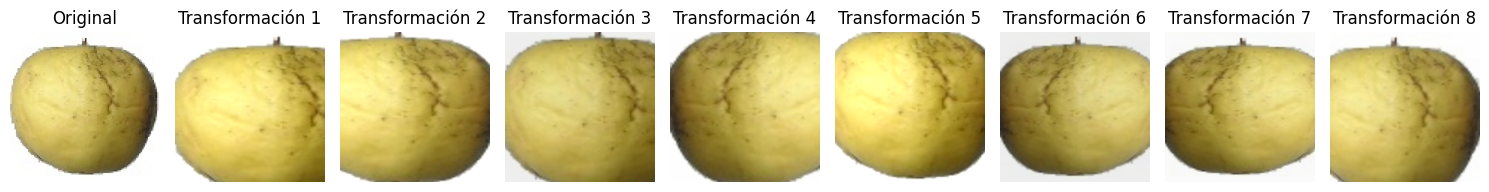

In [15]:
# imagen de ejemplo
image_path = f"{train_folder}/Apple Golden/0_100_1.jpg"
image = Image.open(image_path)

# aplicamos varias transformaciones a la imagen
num_transformations = 8
transformed_images = [aug_data_transforms(image) for _ in range(num_transformations)]

fig, axes = plt.subplots(1, num_transformations + 1, figsize=(15, 3))

# imagen original
axes[0].imshow(image)
axes[0].set_title("Original")
axes[0].axis('off')

# imágenes transformadas
for i, transformed_image in enumerate(transformed_images):
    axes[i + 1].imshow(np.transpose(transformed_image.numpy(), (1, 2, 0)))
    axes[i + 1].set_title(f"Transformación {i + 1}")
    axes[i + 1].axis('off')

plt.tight_layout()
plt.show()

---
## 2) Modelos

In [26]:
# Variable para definir si corremos training o levantamos los pkl de corridas anteriores
RUN_TRAINING = 0

### Funciones de train/test

In [74]:
# Función de entrenamiento y validación
def train_and_evaluate(model, optimizer, criterion, data, epochs, device, filename="", drive_path="/content/drive/My Drive"):
    train_loader, valid_loader = data["train"], data["valid"]

    results = {key: {"train": [], "valid": []} for key in metrics.keys()}
    results["loss"] = {"train": [], "valid": []}
    results["training_time"] = 0.0

    start_time = time.time()
    for epoch in range(epochs):
        # -----------------------
        # Fase de Entrenamiento
        # -----------------------
        model.train()
        train_loss = 0.0
        epoch_metrics = {key: 0.0 for key in metrics.keys()}
        for train_data, train_target in train_loader:
            train_data, train_target = train_data.to(device), train_target.to(device)
            optimizer.zero_grad()
            output = model(train_data)
            loss = criterion(output, train_target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Calcular métricas durante el entrenamiento
            for key, metric in metrics.items():
                metric_value = metric(output, train_target).item()
                epoch_metrics[key] += metric_value

        # Guardar pérdida y métricas promedio de entrenamiento
        avg_train_loss = train_loss / len(train_loader)
        results["loss"]["train"].append(avg_train_loss)
        for key in metrics.keys():
            results[key]["train"].append(epoch_metrics[key] / len(train_loader))

        # -----------------------
        # Fase de Evaluación
        # -----------------------
        model.eval()
        with torch.no_grad():
            valid_loss = 0.0
            epoch_metrics = {key: 0.0 for key in metrics.keys()}
            for data, target in valid_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                valid_loss += loss.item()

                for key, metric in metrics.items():
                    epoch_metrics[key] += metric(output, target).item()

            # Guardar pérdida y métricas promedio de validación
            avg_valid_loss = valid_loss / len(valid_loader)
            results["loss"]["valid"].append(avg_valid_loss)
            for key in metrics.keys():
                results[key]["valid"].append(epoch_metrics[key] / len(valid_loader))

        # -----------------------
        # Impresión de resultados
        # -----------------------
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"  Train - Loss: {avg_train_loss:.4f}, ", end='')
        for key in metrics.keys():
            print(f"{key.capitalize()}: {results[key]['train'][-1]:.4f}, ", end='')
        print()
        print(f"  Valid - Loss: {avg_valid_loss:.4f}, ", end='')
        for key in metrics.keys():
            print(f"{key.capitalize()}: {results[key]['valid'][-1]:.4f}, ", end='')
        print("\n")

    end_time = time.time()
    training_time = end_time - start_time
    results["training_time"] = training_time
    print(f"Tiempo de entrenamiento: {training_time:.2f} s")

    # Guardar modelo y resultados en un archivo .pkl
    if filename != "":
        save_to_pkl(model, results, filename, drive_path)
    # Guardar métricas en archivos
    for key in metrics.keys():
        save_metric(f"{filename}_{key}_train.txt", results[key]["train"])
        save_metric(f"{filename}_{key}_valid.txt", results[key]["valid"])

    return results

---
### Funciones auxiliares

In [75]:
# Funcion para guardar métricas en archivos
def save_metric(filename, values):
    with open(filename, "w") as file:
        for value in values:
            file.write(f"{value}\n")


# Función para guardar el modelo y resultados en un archivo .pkl
def save_to_pkl(model, results, filename, drive_path="/content/drive/My Drive"):
    filepath = os.path.join(drive_path, filename)
    with open(filepath, "wb") as f:
        pickle.dump({"model": model.state_dict(), "results": results}, f)
    print(f"Modelo y resultados guardados en {filepath}")


# Función para leer el archivo .pkl guardado
def read_pkl(filename, drive_path="/content/drive/My Drive"):
    filepath = os.path.join(drive_path, filename)
    with open(filepath, "rb") as f:
        loaded_data = pickle.load(f)
    return loaded_data['model'], loaded_data['results']


# Funcion para imprimir el tamaño del modelo
def print_model_size(model):
    total_params = sum(p.numel() for p in model.parameters())
    model_size = sum(p.numel() * p.element_size() for p in model.parameters())
    print(f"Cantidad de parámetros: {total_params}")
    print(f"Tamaño del modelo: {model_size / (1024 * 1024):.2f} MB")


# Funcion para graficar las metricas
def plot_metrics(title, results):
    fig, axes = plt.subplots(3, 2, figsize=(12, 10))
    metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'loss']
    num_metrics = len(metrics_to_plot)
    num_rows = math.ceil(num_metrics / 2)
    for i, key in enumerate(metrics_to_plot):
        row = i // 2
        col = i % 2
        axes[row, col].plot(results[key]["train"], label=f"Train {key.capitalize()}", marker='o')
        axes[row, col].plot(results[key]["valid"], label=f"Valid {key.capitalize()}", marker='o')
        axes[row, col].set_xlabel("Epoch")
        axes[row, col].set_ylabel(key.capitalize())
        axes[row, col].set_title(f"{title} - {key.capitalize()}")
        axes[row, col].grid(alpha=0.5)
        axes[row, col].legend(loc='lower right')

    if num_metrics % 2 != 0:
        fig.delaxes(axes[num_rows - 1, 1])

    plt.tight_layout()
    plt.show()


# Función para visualizar predicciones correctas e incorrectas
def visualize_predictions_grid(model, data_loader, device, classes=None, num_images=5):
    model.eval()

    correct_predictions = []
    incorrect_predictions = []

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)

            for i in range(data.size(0)):
                if pred[i].item() == target[i].item():
                    if len(correct_predictions) < num_images:
                        correct_predictions.append((data[i], target[i], pred[i]))
                else:
                    if len(incorrect_predictions) < num_images:
                        incorrect_predictions.append((data[i], target[i], pred[i]))

                if len(correct_predictions) == num_images and len(incorrect_predictions) == num_images:
                    break

    # crear la cuadrícula de imágenes
    num_correct = len(correct_predictions)
    num_incorrect = len(incorrect_predictions)
    num_rows = 2
    num_cols = max(num_correct, num_incorrect)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6))

    # mostrar las predicciones correctas
    for i, (image, target, pred) in enumerate(correct_predictions):
        ax = axes[0, i]
        ax.imshow(np.transpose(image.cpu().numpy(), (1, 2, 0)))
        ax.axis('off')
        nombre_clase_real = classes[target.item()] if classes else target.item()
        nombre_clase_predicha = classes[pred.item()] if classes else pred.item()
        titulo = f"Real: {nombre_clase_real}\nPred: {nombre_clase_predicha}"
        ax.set_title(titulo, fontsize=8)

    # mostrar las predicciones incorrectas
    for i, (image, target, pred) in enumerate(incorrect_predictions):
        ax = axes[1, i]
        ax.imshow(np.transpose(image.cpu().numpy(), (1, 2, 0)))
        ax.axis('off')
        nombre_clase_real = classes[target.item()] if classes else target.item()
        nombre_clase_predicha = classes[pred.item()] if classes else pred.item()
        titulo = f"Real: {nombre_clase_real}\nPred: {nombre_clase_predicha}"
        ax.set_title(titulo, fontsize=8)

    # oultar los subplots vacíos
    for i in range(num_correct, num_cols):
        axes[0, i].axis('off')
    for i in range(num_incorrect, num_cols):
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

---
### 2.1) Modelo 1: VGG19

#### 2.1.1) Con el dataset reducido

In [81]:
# Configuración inicial
CANTIDAD_CLASES = 40
BATCH_SIZE = 32
EPOCHS = 15
LEARNING_RATE = 0.0001

# carga de datasets
train_subset = torchvision.datasets.ImageFolder(root=train_subset_folder, transform=aug_data_transforms)
valid_subset = torchvision.datasets.ImageFolder(root=test_subset_folder, transform=data_transforms)
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_subset, batch_size=BATCH_SIZE, shuffle=True)

# carga del modelo pre-entrenado
vgg19_reduced_model = torchvision.models.vgg19(weights=VGG19_Weights.IMAGENET1K_V1)
for param in vgg19_reduced_model.parameters():
    param.requires_grad = False
last_layer_in_features = vgg19_reduced_model.classifier[-1].in_features
vgg19_reduced_model.classifier[-1] = torch.nn.Linear(in_features=last_layer_in_features, out_features=CANTIDAD_CLASES)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg19_reduced_model.to(device)
print_model_size(vgg19_reduced_model)

# definición de métricas
metrics = {
    "accuracy": torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES).to(device),
    "precision": torchmetrics.Precision(task='multiclass', num_classes=CANTIDAD_CLASES, average='macro').to(device),
    "recall": torchmetrics.Recall(task='multiclass', num_classes=CANTIDAD_CLASES, average='macro').to(device),
    "f1": torchmetrics.F1Score(task='multiclass', num_classes=CANTIDAD_CLASES, average='macro').to(device),
}

# configuración del optimizador y función de pérdida
optimizer = torch.optim.Adam(vgg19_reduced_model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss()
data = {"train": train_loader, "valid": valid_loader}

Cantidad de parámetros: 139734120
Tamaño del modelo: 533.04 MB


In [58]:
pkl_filename = "vgg19_reduced.pkl"
if RUN_TRAINING:
    vgg19_reduced_results = train_and_evaluate(vgg19_reduced_model, optimizer, criterion, data, EPOCHS, device, pkl_filename)
else:
    model_state_dict, vgg19_reduced_results = read_pkl(pkl_filename)
    vgg19_reduced_model.load_state_dict(model_state_dict)

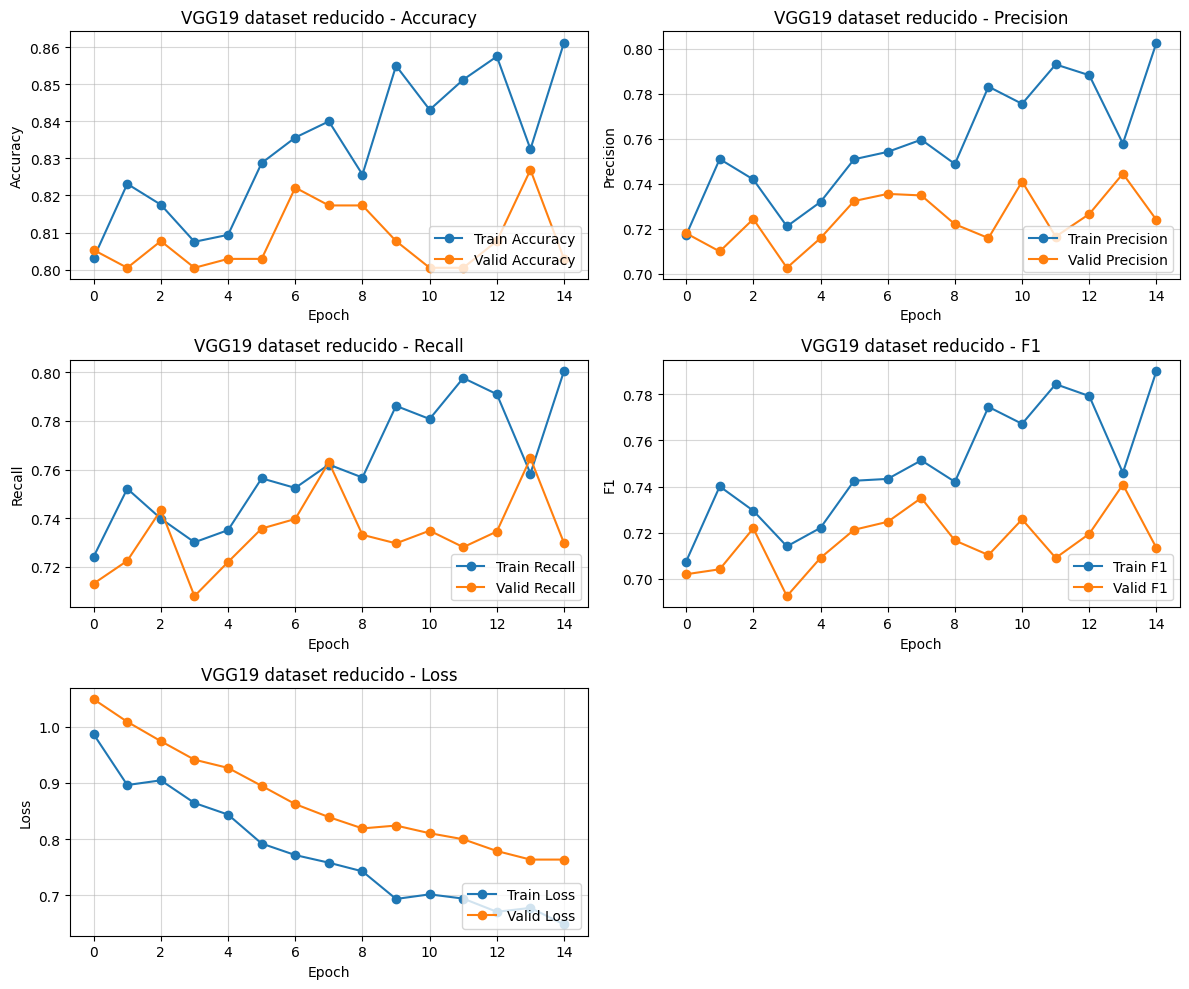

In [59]:
plot_metrics("VGG19 dataset reducido", vgg19_reduced_results)

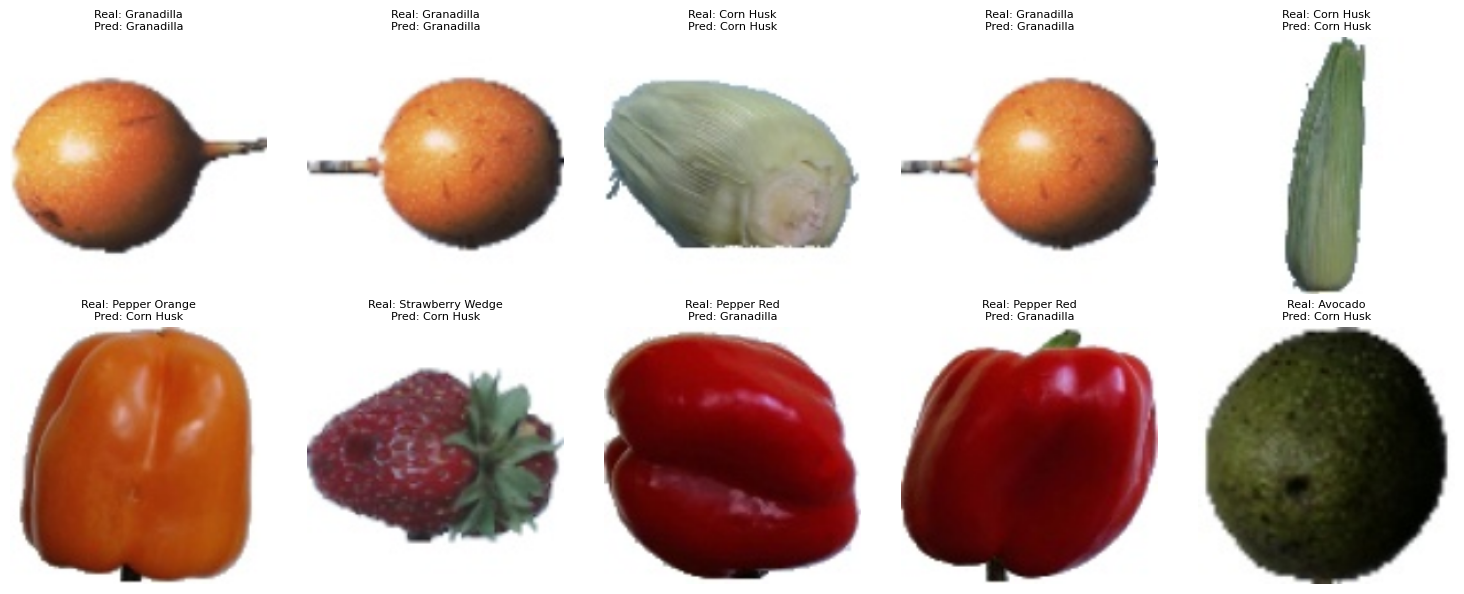

In [82]:
visualize_predictions_grid(vgg19_reduced_model, valid_loader, device, classes_subset)

---
#### 2.1.2) Búsqueda de HP

In [ ]:
# TODO

---
#### 2.1.3) Con el dataset completo

In [ ]:
# Configuración inicial
CANTIDAD_CLASES = 121
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.0001

# carga de datasets
train_set = torchvision.datasets.ImageFolder(root=train_folder, transform=aug_data_transforms)
valid_set = torchvision.datasets.ImageFolder(root=test_folder, transform=data_transforms)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=True)

# carga del modelo pre-entrenado
vgg19_full_model = torchvision.models.vgg19(weights=VGG19_Weights.IMAGENET1K_V1)
for param in vgg19_full_model.parameters():
    param.requires_grad = False
last_layer_in_features = vgg19_full_model.classifier[-1].in_features
vgg19_full_model.classifier[-1] = torch.nn.Linear(in_features=last_layer_in_features, out_features=CANTIDAD_CLASES)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg19_full_model.to(device)
print_model_size(vgg19_full_model)

# definición de métricas
metrics = {
    "accuracy": torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES).to(device),
    "precision": torchmetrics.Precision(task='multiclass', num_classes=CANTIDAD_CLASES, average='macro').to(device),
    "recall": torchmetrics.Recall(task='multiclass', num_classes=CANTIDAD_CLASES, average='macro').to(device),
    "f1": torchmetrics.F1Score(task='multiclass', num_classes=CANTIDAD_CLASES, average='macro').to(device),
}

# configuración del optimizador y función de pérdida
optimizer = torch.optim.Adam(vgg19_full_model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss()
data = {"train": train_loader, "valid": valid_loader}

In [ ]:
pkl_filename = "vgg19_full.pkl"
if RUN_TRAINING:
    vgg19_full_results = train_and_evaluate(vgg19_full_model, optimizer, criterion, data, EPOCHS, device, pkl_filename)
else:
    model_state_dict, vgg19_full_results = read_pkl(pkl_filename)
    vgg19_full_model.load_state_dict(model_state_dict)

In [ ]:
plot_metrics("VGG19 dataset completo", vgg19_full_results)

---
### 2.2) Modelo 2: MobileNetV2

#### 2.2.1) Con el dataset reducido

In [76]:
# Configuración inicial
CANTIDAD_CLASES = 40
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.0001

# carga de datasets
train_subset = torchvision.datasets.ImageFolder(root=train_subset_folder, transform=aug_data_transforms)
valid_subset = torchvision.datasets.ImageFolder(root=test_subset_folder, transform=data_transforms)
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_subset, batch_size=BATCH_SIZE, shuffle=True)

# carga del modelo pre-entrenado
mobilenet_reduced_model = mobilenet_v2(weights='MobileNet_V2_Weights.IMAGENET1K_V1')
for param in mobilenet_reduced_model.parameters():
    param.requires_grad = False
last_layer_in_features = mobilenet_reduced_model.classifier[1].in_features
mobilenet_reduced_model.classifier[1] = torch.nn.Linear(in_features=last_layer_in_features, out_features=CANTIDAD_CLASES)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobilenet_reduced_model.to(device)
print_model_size(mobilenet_reduced_model)

# definición de métricas
metrics = {
    "accuracy": torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES).to(device),
    "precision": torchmetrics.Precision(task='multiclass', num_classes=CANTIDAD_CLASES, average='macro').to(device),
    "recall": torchmetrics.Recall(task='multiclass', num_classes=CANTIDAD_CLASES, average='macro').to(device),
    "f1": torchmetrics.F1Score(task='multiclass', num_classes=CANTIDAD_CLASES, average='macro').to(device),
}

# configuración del optimizador y función de pérdida
optimizer = torch.optim.Adam(mobilenet_reduced_model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss()
data = {"train": train_loader, "valid": valid_loader}

Cantidad de parámetros: 2275112
Tamaño del modelo: 8.68 MB


In [77]:
pkl_filename = "mobilenet_reduced.pkl"
if RUN_TRAINING:
    mobilenet_reduced_results = train_and_evaluate(mobilenet_reduced_model, optimizer, criterion, data, EPOCHS, device, pkl_filename)
else:
    model_state_dict, mobilenet_reduced_results = read_pkl(pkl_filename)
    mobilenet_reduced_model.load_state_dict(model_state_dict)

Epoch 1/20
  Train - Loss: 3.5308, Accuracy: 0.0919, Precision: 0.0726, Recall: 0.0716, F1: 0.0662, 
  Valid - Loss: 3.2655, Accuracy: 0.2716, Precision: 0.1754, Recall: 0.2084, F1: 0.1742, 

Epoch 2/20
  Train - Loss: 3.0489, Accuracy: 0.3731, Precision: 0.2840, Recall: 0.2896, F1: 0.2717, 
  Valid - Loss: 2.8026, Accuracy: 0.5769, Precision: 0.4548, Recall: 0.4992, F1: 0.4576, 

Epoch 3/20
  Train - Loss: 2.6139, Accuracy: 0.6125, Precision: 0.4917, Recall: 0.5023, F1: 0.4817, 
  Valid - Loss: 2.3944, Accuracy: 0.7332, Precision: 0.6084, Recall: 0.6482, F1: 0.6127, 

Epoch 4/20
  Train - Loss: 2.2407, Accuracy: 0.7556, Precision: 0.6575, Recall: 0.6569, F1: 0.6436, 
  Valid - Loss: 2.0545, Accuracy: 0.7933, Precision: 0.7118, Recall: 0.7202, F1: 0.7038, 

Epoch 5/20
  Train - Loss: 1.9419, Accuracy: 0.8156, Precision: 0.7270, Recall: 0.7278, F1: 0.7169, 
  Valid - Loss: 1.7743, Accuracy: 0.8365, Precision: 0.7494, Recall: 0.7698, F1: 0.7493, 

Epoch 6/20
  Train - Loss: 1.6893, Accur

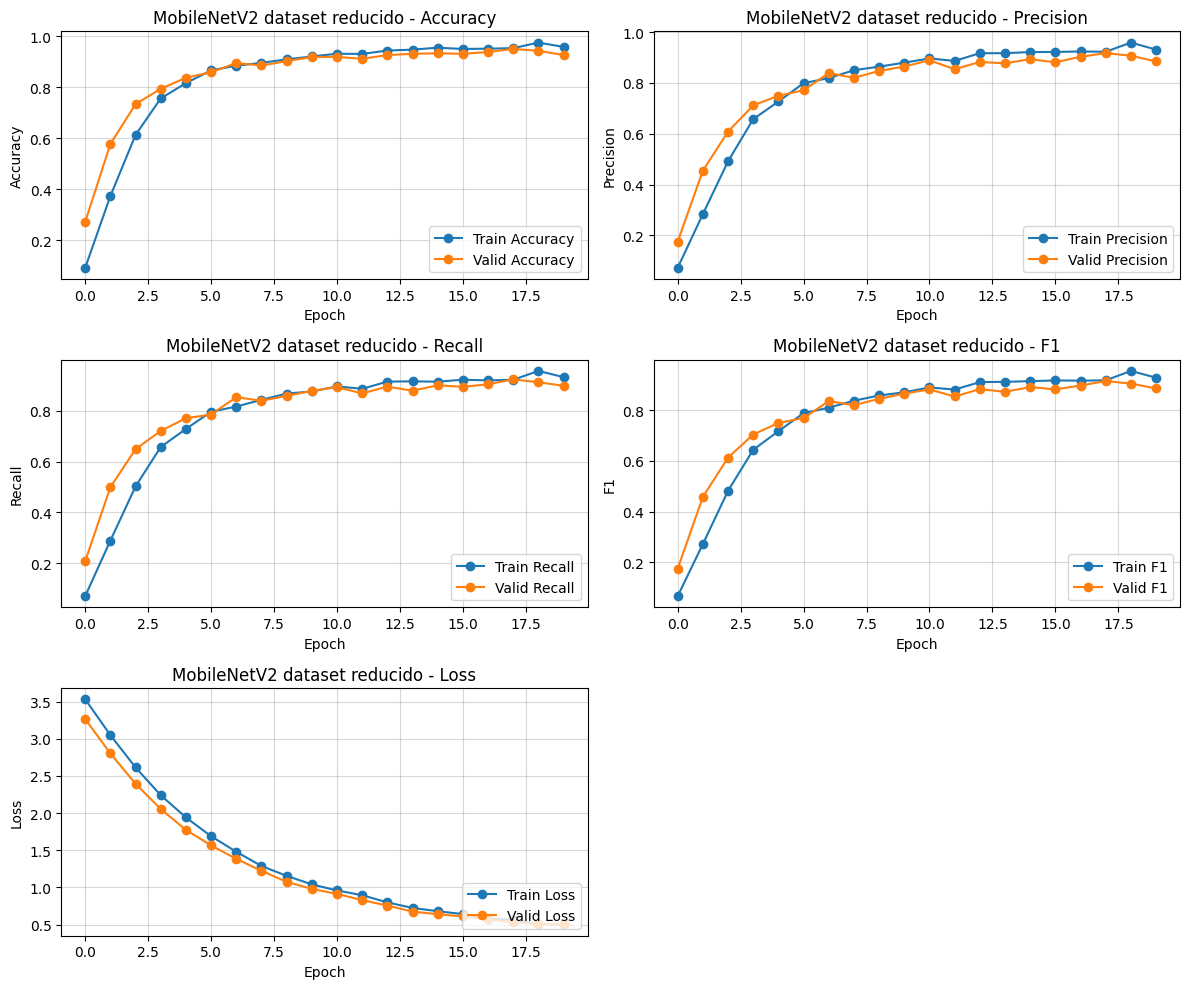

In [78]:
plot_metrics("MobileNetV2 dataset reducido", mobilenet_reduced_results)

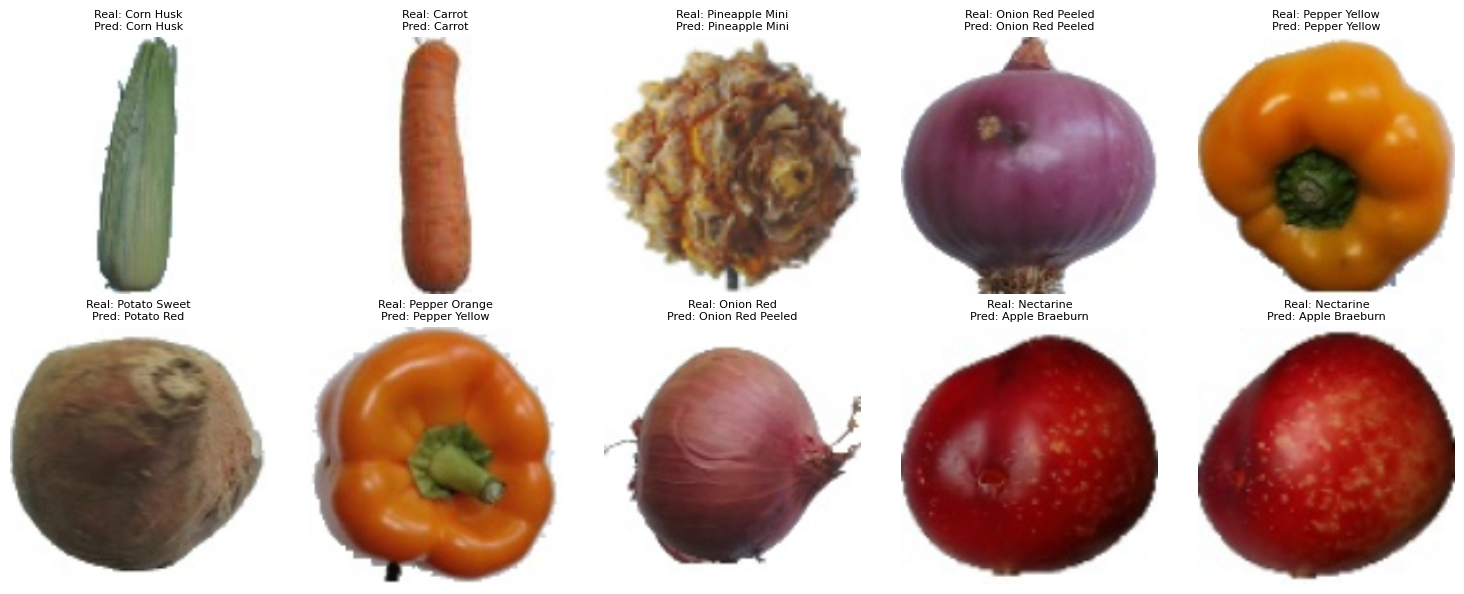

In [80]:
visualize_predictions_grid(mobilenet_reduced_model, valid_loader, device, classes_subset)

---
#### 2.2.2) Búsqueda de HP

In [ ]:
# TODO

---
#### 2.2.3) Con el dataset completo

In [84]:
# Configuración inicial
CANTIDAD_CLASES = 121
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.0001

# carga de datasets
train_set = torchvision.datasets.ImageFolder(root=train_folder, transform=aug_data_transforms)
valid_set = torchvision.datasets.ImageFolder(root=test_folder, transform=data_transforms)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=True)

# carga del modelo pre-entrenado
mobilenet_full_model = mobilenet_v2(weights='MobileNet_V2_Weights.IMAGENET1K_V1')
for param in mobilenet_full_model.parameters():
    param.requires_grad = False
last_layer_in_features = mobilenet_full_model.classifier[1].in_features
mobilenet_full_model.classifier[1] = torch.nn.Linear(in_features=last_layer_in_features, out_features=CANTIDAD_CLASES)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobilenet_full_model.to(device)
print_model_size(mobilenet_full_model)

# definición de métricas
metrics = {
    "accuracy": torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES).to(device),
    "precision": torchmetrics.Precision(task='multiclass', num_classes=CANTIDAD_CLASES, average='macro').to(device),
    "recall": torchmetrics.Recall(task='multiclass', num_classes=CANTIDAD_CLASES, average='macro').to(device),
    "f1": torchmetrics.F1Score(task='multiclass', num_classes=CANTIDAD_CLASES, average='macro').to(device),
}

# configuración del optimizador y función de pérdida
optimizer = torch.optim.Adam(mobilenet_full_model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss()
data = {"train": train_loader, "valid": valid_loader}

Cantidad de parámetros: 2378873
Tamaño del modelo: 9.07 MB


In [85]:
pkl_filename = "mobilenet_full.pkl"
if RUN_TRAINING:
    mobilenet_full_results = train_and_evaluate(mobilenet_full_model, optimizer, criterion, data, EPOCHS, device, pkl_filename)
else:
    model_state_dict, mobilenet_full_results = read_pkl(pkl_filename)
    mobilenet_full_model.load_state_dict(model_state_dict)

RuntimeError: Error(s) in loading state_dict for MobileNetV2:
	size mismatch for classifier.1.weight: copying a param with shape torch.Size([141, 1280]) from checkpoint, the shape in current model is torch.Size([121, 1280]).
	size mismatch for classifier.1.bias: copying a param with shape torch.Size([141]) from checkpoint, the shape in current model is torch.Size([121]).

In [ ]:
plot_metrics("MobileNetV2 dataset completo", mobilenet_full_results)

---
#### 2.2.4) Resultados sin data augmentation

In [ ]:
# TODO

---
#### 2.2.5) Resultados sin Transfer Learning


In [ ]:
# TODO

---